<a href="https://colab.research.google.com/github/AnyaPopkova/JETP_2D/blob/main/2D_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import shutil
import os
def reinit_tensorboard(clear_log = True):
  logs_base_dir = "/content/runs" # Directory for log files
  if clear_log:
    shutil.rmtree(logs_base_dir, ignore_errors = True)
    os.makedirs(logs_base_dir, exist_ok=True)
  %reload_ext tensorboard
  %tensorboard --logdir {logs_base_dir}

In [3]:
import glob
from PIL import Image
from torch.utils.data import Dataset
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt

In [4]:
np.random.seed(seed=42)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
#Dataset
from torch.utils.data import Dataset
import numpy as np

class Dataset(Dataset):
    def __init__(self, root_dir, partition, size=48, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.partition = partition

        self.img1_path = os.listdir('%s/%s/1/' % (self.root_dir, partition))
        self.mask_path = os.listdir('%s/%s/mask/' % (self.root_dir, partition))

    def __len__(self):
        return len(self.img1_path)

    def __getitem__(self, idx):

        img1 = Image.open('%s/%s/1/%s' % (self.root_dir, self.partition, self.img1_path[idx]))
        mask = np.array(Image.open('%s/%s/mask/%s' % (self.root_dir, self.partition, self.mask_path[idx])))

        if self.transform:
            img1 = self.transform(img1)
            mask = self.transform(mask)

        return img1, mask

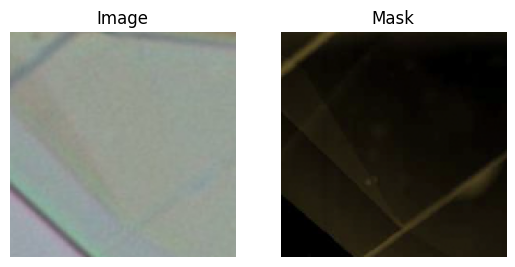

In [62]:
#element visualisation
img1 = Image.open('/content/2d/test/img1.png')
mask1 = Image.open('/content/2d/test/mask1.png')

fig,ax = plt.subplots(ncols=2)
ax[0].imshow(img1)
ax[1].imshow(mask1)

ax[0].set_title('Image')
ax[1].set_title('Mask')

for a in ax:
    a.axis('off')

In [63]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, RandomRotation, Normalize, RandomHorizontalFlip, RandomAutocontrast, RandomVerticalFlip

transform = transforms.Compose([ToTensor(),
                              transforms.Normalize([0.2823, 0.2935, 0.2716],[0.1515, 0.1607, 0.1534])])

transform_1 = transforms.Compose([RandomHorizontalFlip(p=0.5), RandomVerticalFlip(p=0.5), RandomRotation(degrees=(0, 180))])

In [ ]:
desination_dir = '/content/2d/'
batch_size = 32

dataset = Dataset(desination_dir, partition='train', transform = transform)

trainset,  valset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)) - int(len(dataset)*0.8)])

train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = False)
val_loader = DataLoader(valset, batch_size = batch_size, shuffle = False)

In [5]:
# network structure
from torch import nn

class Unet(nn.Module):
    def __init__(self, channels = 16, kernel_size = 3):
        super(Unet, self).__init__()
        self.channels = channels
        self.kernel_size = kernel_size

        self.block1 = nn.Sequential(
            nn.Conv2d(3, self.channels, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.Conv2d(self.channels, self.channels, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU())

        self.block2 = nn.Sequential(
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(self.channels, self.channels * 2, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.Conv2d(self.channels * 2, self.channels * 2, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU())

        self.block3 = nn.Sequential(
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(self.channels * 2, self.channels * 2 * 2, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.Conv2d(self.channels * 4, self.channels * 4, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels * 4, self.channels * 4, kernel_size = self.kernel_size, stride = 2, padding = 1, output_padding=1))

        self.block4 = nn.Sequential(
            nn.Conv2d(self.channels * 6, self.channels * 4, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.Conv2d(self.channels * 4, self.channels * 2, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels * 2, self.channels * 2, kernel_size = self.kernel_size, stride = 2, padding = 1, output_padding=1)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(self.channels * 3, self.channels * 2, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.Conv2d(self.channels * 2, self.channels, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.Conv2d(self.channels, 1, kernel_size=1),
            nn.ReLU()
        )


    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = torch.cat((x2, x3), dim = 1)
        x5 = self.block4(x4)
        x6 = torch.cat((x5, x1), dim = 1)
        x7 = self.block5(x6)
        return x7

In [6]:
#network for (1х1) convolution

class Ones(nn.Module):
    def __init__(self, channels = 16, kernel_size = 1):
        super(Unet, self).__init__()
        self.channels = channels
        self.kernel_size = kernel_size

        self.block1 = nn.Sequential(
            nn.Conv2d(3, self.channels, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.Conv2d(self.channels, self.channels, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.Conv2d(self.channels, self.channels*2, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.Conv2d(self.channels*2, self.channels*2, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.Conv2d(self.channels*2, self.channels, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU(),
            nn.Conv2d(self.channels, 1, kernel_size=self.kernel_size, padding = 1),
            nn.ReLU())

    def forward(self, x):
        x1 = self.block1(x)
        return x1 # predicted map

In [7]:
#Loss
class Loss(nn.Module):

    def __init__(self, k = 1, epsilon=0):
        super().__init__()
        self.epsilon = epsilon
        self.k = k

    def forward(self, predict, target):
        predict = predict.flatten(1)
        target = target.flatten(1)

        if self.k == 0:
          #MAE
          loss = torch.sum(torch.abs(torch.sub(predict, target))) + self.epsilon
          #print("loss", loss)

        else:
          #MSE
          loss = torch.sum(torch.sqrt(torch.sub(predict, target))) + self.epsilon

        return loss.mean()  # over batch

In [8]:
def train(model, criterion, optimizer, epoch=None, masks_in_progress=[]):
    ep_loss = 0
    model.train()

    for img_batch, masks_batch in train_loader:
        optimizer.zero_grad()
        output = model(img_batch.to(device))
        loss = criterion(output, masks_batch.to(device))
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()


    val_loss = 0
    for i, batch in enumerate(val_loader):
        with torch.no_grad():
            img_batch, masks_batch = batch
            output = model(img_batch.to(device))
            loss = criterion(output, masks_batch.to(device))
            val_loss += loss.item()
            if i == 0:
                masks_in_progress.append(output[0].cpu())

    accuracy = validate(model,val_loader,device)

    return ep_loss, val_loss, accuracy

In [ ]:
def compute_Q(preds, truth, thres=0.5):     #accuracy
    preds1 = preds.to("cpu").detach().numpy()
    truth1 = truth.to("cpu").detach().numpy()
    Q = np.mean(preds1 - truth1 < thres) * 100 # %

    return Q

In [ ]:
def validate(model, criterion, optimizer, epoch=None, masks_in_progress=[]):
    model.eval()
    mcc = []

    for img_batch, masks_batch in enumerate(val_loader):
                inputs = img_batch.to(device)
                masks = masks_batch.to(device)

                outputs = model(inputs)
                accuracy = compute_Q(inputs, outputs, 0.01)

    return accuracy

In [ ]:
model = Unet().to(device)
criterion = Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
with torch.no_grad():
    masks_in_progress = [model(next(iter(val_loader))[0].to(device))[0].cpu()] # Add mask before train

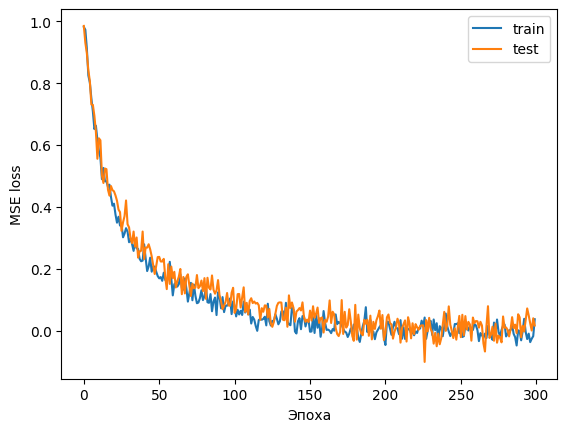

In [1]:
tr = []
test = []
acc = []

for epoch in range(300):
    tr1, test1, acc1 = train(model, criterion, optimizer, epoch, masks_in_progress)
    tr.append(tr1)
    test.append(test1)
    acc.append(acc1)

x = np.arange(0, 300, 1)
plt.plot(x, tr1, label="train")
plt.plot(x, test, label="test" )
plt.xlabel("Эпоха")
plt.ylabel("MSE loss")

plt.savefig('pred1.png')
plt.show()

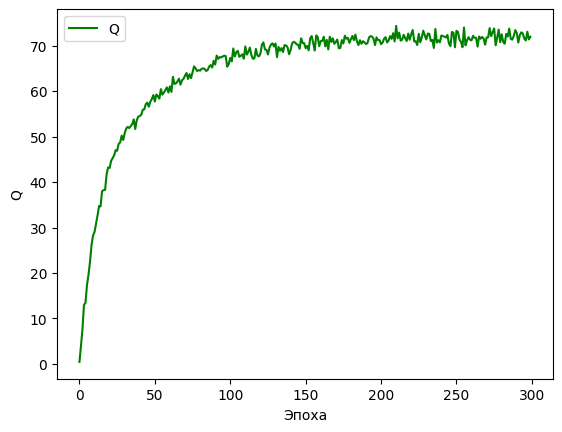

In [12]:
plt.plot(x, acc, label="Q", color = "green")
plt.xlabel("Эпоха")
plt.ylabel("Q")
plt.legend()
plt.show()

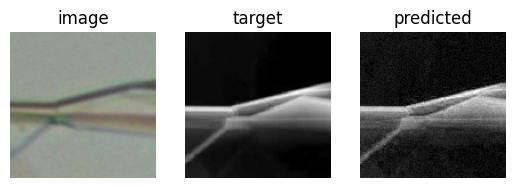

In [35]:
idx = 10

for img_batch, masks_batch in val_loader:

  img = img_batch[idx]
  mask = masks_batch[idx]
  mask_pr = model(img)

  fig,ax = plt.subplots(ncols=3)
  ax[0].imshow(img)
  ax[1].imshow(mask, cmap = 'gray')
  ax[2].imshow(mask_pr, cmap = 'gray')

  ax[0].set_title('image')
  ax[1].set_title('target')
  ax[2].set_title('predicted')


  for a in ax:
    a.axis('off')